# **TANGOS: The Agile Numerical Galaxy Organisation System**


## Step 1: Installation
To install: <br>
\>>git clone https://github.com/anchwr/tangos.git <br>
\>>cd tangos <br>
\>>python setup.py develop <br>
This will install my fork of tangos, which works with Enzo outputs. You can install the public version of tangos by typing <br>
\>>pip install tangos <br>
but you won't be able to use certain functions (e.g., calculate_all) that need access to the handler class that was used to create the database. <br>
More detailed instructions can be found at: https://pynbody.github.io/tangos/index.html <br>

## Step 2: Download a database
Basic database containing info for Tempest RDs can be found at: https://github.com/foggie-sims/foggie/blob/master/foggie/halo_infos/008508/nref11c_nref9f/Tempest.9f11c.RD.db <br>(Size as of 8/2/2021: ~10 MB) <br> <br>
You'll also need to tell tangos where to find your database. Add the following lines to your .bashrc (.bash_profile, etc):<br>
export TANGOS_SIMULATION_FOLDER = /path/to/folder/containing/tangos/database/ <br>
export TANGOS_DB_CONNECTION = /path/to/folder/containing/tangos/database/Tempest.9f11c.RD.db <br>
So, for me, this is:<br>
export TANGOS_SIMULATION_FOLDER=/Users/Anna/Research/Outputs/tangostest/ <br>
export TANGOS_DB_CONNECTION=/Users/Anna/Research/Outputs/tangostest/Tempest.9f11c.RD.db


## Step 3: Check that you can load the database
(Source your .bashrc and reload this notebook if necessary) <br>


In [1]:
import tangos as db

Which simulations do we have access to? If all went well, you should see <Simulation("Tempest.9f11c.RD")>

In [2]:
db.all_simulations()

/Users/anna/tangos/tangos/query.py:14: SAWarning: relationship 'TimeStep.trackers' will copy column timesteps.id to column halos.timestep_id, which conflicts with relationship(s): 'TimeStep.halos' (copies timesteps.id to halos.timestep_id). If this is not the intention, consider if these relationships should be linked with back_populates, or if viewonly=True should be applied to one or more if they are read-only. For the less common case that foreign key constraints are partially overlapping, the orm.foreign() annotation can be used to isolate the columns that should be written towards.   To silence this warning, add the parameter 'overlaps="halos"' to the 'TimeStep.trackers' relationship.
  return session.query(Simulation).all()
/Users/anna/tangos/tangos/query.py:14: SAWarning: relationship 'TimeStep.bhs' will copy column timesteps.id to column halos.timestep_id, which conflicts with relationship(s): 'TimeStep.halos' (copies timesteps.id to halos.timestep_id), 'TimeStep.trackers' (cop

[<Simulation("Tempest.9f11c.RD")>]

Load Tempest:

In [3]:
sim = db.get_simulation('Tempest.9f11c.RD')

Check that you can see all of the timesteps (you should see a list showing RD0012-RD0042):

In [4]:
sim.timesteps

[<TimeStep 'Tempest.9f11c.RD/RD0012/RD0012' z=6.00 t=0.95 Gyr>,
 <TimeStep 'Tempest.9f11c.RD/RD0013/RD0013' z=5.00 t=1.19 Gyr>,
 <TimeStep 'Tempest.9f11c.RD/RD0014/RD0014' z=4.00 t=1.57 Gyr>,
 <TimeStep 'Tempest.9f11c.RD/RD0015/RD0015' z=3.50 t=1.83 Gyr>,
 <TimeStep 'Tempest.9f11c.RD/RD0016/RD0016' z=3.00 t=2.18 Gyr>,
 <TimeStep 'Tempest.9f11c.RD/RD0017/RD0017' z=2.75 t=2.40 Gyr>,
 <TimeStep 'Tempest.9f11c.RD/RD0018/RD0018' z=2.50 t=2.66 Gyr>,
 <TimeStep 'Tempest.9f11c.RD/RD0019/RD0019' z=2.25 t=2.96 Gyr>,
 <TimeStep 'Tempest.9f11c.RD/RD0020/RD0020' z=2.00 t=3.33 Gyr>,
 <TimeStep 'Tempest.9f11c.RD/RD0021/RD0021' z=1.75 t=3.78 Gyr>,
 <TimeStep 'Tempest.9f11c.RD/RD0022/RD0022' z=1.50 t=4.33 Gyr>,
 <TimeStep 'Tempest.9f11c.RD/RD0023/RD0023' z=1.40 t=4.59 Gyr>,
 <TimeStep 'Tempest.9f11c.RD/RD0024/RD0024' z=1.30 t=4.88 Gyr>,
 <TimeStep 'Tempest.9f11c.RD/RD0025/RD0025' z=1.20 t=5.19 Gyr>,
 <TimeStep 'Tempest.9f11c.RD/RD0026/RD0026' z=1.10 t=5.54 Gyr>,
 <TimeStep 'Tempest.9f11c.RD/RD0027/RD00

Let's look at RD0042. There are a couple of ways to select an individual timestep. My preferred way is just via indexing. There are 31 timesteps here total, so the most recent is:

In [5]:
sim[30]

<TimeStep 'Tempest.9f11c.RD/RD0042/RD0042' z=0.00 t=13.76 Gyr>

However, if you know the name of the timestep, but not its index, you can also access it that way:

In [6]:
db.get_timestep('Tempest.9f11c.RD/%42')

<TimeStep 'Tempest.9f11c.RD/RD0042/RD0042' z=0.00 t=13.76 Gyr>

We can access individual halos in much the same way:

In [7]:
sim[30][1]

<Halo 'Tempest.9f11c.RD/RD0042/RD0042/halo_1' | NDM=281333 Nstar=0 Ngas=0>

and

In [8]:
db.get_halo('Tempest.9f11c.RD/%42/halo_1')

<Halo 'Tempest.9f11c.RD/RD0042/RD0042/halo_1' | NDM=281333 Nstar=0 Ngas=0>

are equivalent. Tangos automatically sorts halos by the number of dark matter particles that they possess, so halo 1 is the most massive halo, halo 2 is the next massive, and so on.

## Step 4: Look at what properties are actually stored in the database

The utility of tangos comes from the fact that you can calculate the same properties for every halo once, store them, and then rapidly access those properties without having to load the simulation itself into yt (or pynbody). You can check which properties exist for a given halo:

In [9]:
sim[30][1].keys()

['consistent_trees_id',
 'Mvir',
 'Mtot',
 'M200c',
 'Rvir',
 'X',
 'Y',
 'Z',
 'Spin_DM_B',
 'X_cu',
 'Y_cu',
 'Z_cu',
 'Center',
 'Center_cu',
 'M_gas',
 'M_coldgas',
 'M_star',
 'ContamFrac',
 'VX',
 'VY',
 'VZ',
 'consistent_trees_link',
 'consistent_trees_link',
 'consistent_trees_link']

These will vary depending on which halo finder was used on the original simulation and which custom properties your db creator has stored in the database. In this case, rockstar and consistent-trees have been used to find the halos and link them across timesteps. Many of the properties (e.g., Mvir, Center) come directly from the rockstar halo catalogs (albeit converted into physical units). Other properties (e.g., M_star, ContamFrac) are custom. Descriptions of each property and the relevant units are available at: https://github.com/foggie-sims/foggie/blob/master/foggie/halo_infos/008508/nref11c_nref9f/tangos.README.txt . I will do my best to keep this up to date!

We can calculate a single property for a single halo:

In [10]:
sim[30][1]['M_coldgas']

17251749934.381973

Or we can calculate multiple properties for every halo in this timestep simultaneously:

/Users/anna/anaconda3/envs/astroconda/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log10
  # Remove the CWD from sys.path while we load stuff.


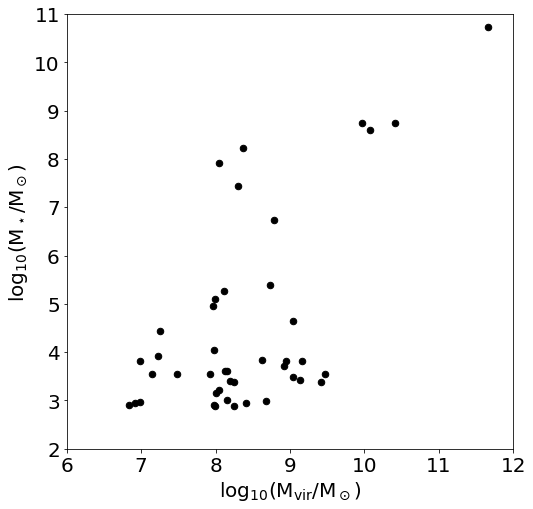

In [11]:
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 20

Mh, Ms = sim[30].calculate_all('Mvir','M_star')

plt.figure(figsize=(8,8))
plt.plot(np.log10(Mh),np.log10(Ms),'k.',markersize=13)
plt.xlabel('log$_{10}$(M$_\mathrm{vir}$/M$_\odot$)',fontsize=20)
plt.ylabel('log$_{10}$(M$_\star$/M$_\odot$)',fontsize=20)
plt.xlim(6,12)
plt.ylim(2,11)
plt.show()

Something to note: when we call "calculate_all", tangos processes the halos in the order they were read in from the halo catalog, NOT the order they are in the database. Each halo has a few different IDs. The important ones here are halo_number (the number of the halo in the database) and finder_id (the number of the halo in the rockstar halo catalog). You can see that these differ pretty drastically:

In [12]:
print (sim[30][1].halo_number)
print (sim[30][1].finder_id)

1
182


Because of this, it's a good idea to include halo_number in the list of quantities you're calculating if you decide to call calculate_all so that you have something to sort by if you need to find an individual halo:

In [ ]:
Mg, hid = sim[22].calculate_all('M_gas','halo_number()')
order = np.argsort(hid)
print (Mg[order])

## Step 5: Travel through time

Tangos links halos across time either through its own bridging program or by reading in output from a merger tree. This allows us to calculate properties for halos at multiple points in time. We can go just one timestep back:

In [13]:
sim[30][3].calculate('earlier(1).Mvir')

11447050359.71223

Or we can look at the evolution of this property over every available timestep:

In [14]:
sim[30][3].calculate_for_progenitors('Mvir')

[array([1.18024460e+10, 1.14470504e+10, 1.14387050e+10, 1.09735252e+10,
        9.71438849e+09, 9.34230216e+09, 9.01453237e+09, 8.19266187e+09,
        7.90949640e+09, 7.75251799e+09, 7.50676259e+09, 7.36661871e+09,
        7.06388489e+09, 6.86402878e+09, 6.81956835e+09, 6.70992806e+09,
        6.75151079e+09, 6.66546763e+09, 6.16014388e+09, 4.20805755e+09,
        3.57079137e+09, 2.76561151e+09])]

Note: the value for the timestep you started with (RD0042) is the first entry while the value for the earliest timestep this halo is traced to (RD0021) is the last entry.

We can also go forwards in time:

Text(0, 0.5, 'log$_{10}$(M$_\\mathrm{vir}$/M$_\\odot$)')

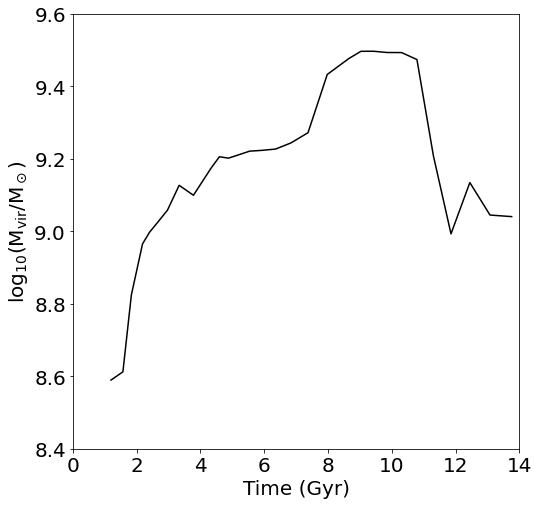

In [15]:
mv, t = sim[1][18].calculate_for_descendants('Mvir','t()')
plt.figure(figsize=(8,8))
plt.plot(t,np.log10(mv),'k-')
plt.xlim(0,14)
plt.ylim(8.4,9.6)
plt.xlabel('Time (Gyr)',fontsize=20)
plt.ylabel('log$_{10}$(M$_\mathrm{vir}$/M$_\odot$)',fontsize=20)

We can also look at how mass grows by directly looking at mergers. There are a number of ways to do this. If you just want to know if a halo experienced a merger between one timestep and the previous one, you can just look at the halo keys. If you see more than one 'consistent_trees_link' entry, there's been a recent merger!

In [16]:
sim[30][4].keys()

['consistent_trees_id',
 'Mvir',
 'Mtot',
 'M200c',
 'Rvir',
 'X',
 'Y',
 'Z',
 'Spin_DM_B',
 'X_cu',
 'Y_cu',
 'Z_cu',
 'Center',
 'Center_cu',
 'M_gas',
 'M_coldgas',
 'M_star',
 'ContamFrac',
 'VX',
 'VY',
 'VZ',
 'consistent_trees_link',
 'consistent_trees_link']

Consistent_trees_link returns halo objects from the previous timestep that are part of the halo in the current timestep, so you can use it directly to access the properties of the merging halos. 

In [17]:
sim[30][4]['consistent_trees_link']

[<Halo 'Tempest.9f11c.RD/RD0041/RD0041/halo_5' | NDM=7591 Nstar=0 Ngas=0>,
 <Halo 'Tempest.9f11c.RD/RD0041/RD0041/halo_55' | NDM=216 Nstar=0 Ngas=0>]

For instance, we can find out the mass ratio of the merging halos:

In [18]:
sim[30][4]['consistent_trees_link'][0]['Mvir']/sim[30][4]['consistent_trees_link'][1]['Mvir']

49.73221117061974

You can also grab the entire merger history of a halo at once

In [19]:
import tangos.examples.mergers as tmer

z,rat,hobj = tmer.get_mergers_of_major_progenitor(sim[30][1])
print ('Redshifts of mergers:\n',z)
print ('Mass ratios of mergers:\n',rat)
print ('Halos involved in mergers:\n',hobj)

Redshifts of mergers:
 [0.         0.         0.04999999 0.04999999 0.04999999 0.09999997
 0.09999997 0.09999997 0.09999997 0.09999997 0.09999997 0.09999997
 0.09999997 0.09999997 0.09999997 0.09999997 0.09999997 0.09999997
 0.09999997 0.19999999 0.19999999 0.19999999 0.19999999 0.19999999]
Mass ratios of mergers:
 [1.64022222e+03 3.39356322e+03 2.09008359e+02 2.95758065e+03
 2.50050000e+03 1.13405195e+03 2.36005405e+03 8.39634615e+02
 1.22414019e+03 2.42561111e+03 1.25342584e+03 2.33898214e+03
 1.19619178e+03 1.70107792e+03 1.31641206e+03 1.94048889e+03
 8.85020270e+02 2.25832759e+03 1.95497015e+03 2.88607595e+00
 1.80952381e+00 9.70820045e-04 2.09174312e+00 7.60253418e-02]
Halos involved in mergers:
 [(<Halo 'Tempest.9f11c.RD/RD0041/RD0041/halo_1' | NDM=295240 Nstar=0 Ngas=0>, <Halo 'Tempest.9f11c.RD/RD0041/RD0041/halo_63' | NDM=180 Nstar=0 Ngas=0>), (<Halo 'Tempest.9f11c.RD/RD0041/RD0041/halo_1' | NDM=295240 Nstar=0 Ngas=0>, <Halo 'Tempest.9f11c.RD/RD0041/RD0041/halo_122' | NDM=87 N

This is a fairly complex merger history and likely better processed visually. We can do that by launching tangos web server:<br>
\>>tangos serve <br>
You should see something like "Serving on http://555.5.5.5:6543". Enter the address into your web browser and click on the simulation you want, followed by the timestep and the halo. Clicking on the circle next to "merger tree" will give you a visual representation of your halo's merger history. You can also plot just about every other quantity in the database against time (or any other quantity), too!

## Step 6: Use tangos and yt together

Let's go back to the halo that we traced forwards in time a few steps ago. We can see that this halo loses mass, presumably through tidal stripping. Thus far, we've done all of our analysis without accessing the actual simulation data or loading in yt. However, if we want to visualize the tidal debris, we'll need to use both tangos and yt. Using tangos, we can identify when the halo was at its maximum mass, where it was located at that time, and how large it was.

In [20]:
hn,rvir,cen,mv = sim[1][18].calculate_for_descendants('halo_number()','Rvir','Center_cu','Mvir')
maxm = np.argmax(mv)
print (sim[int(1+maxm)][int(hn[maxm])])
r = rvir[maxm]
c = cen[maxm]

<Halo 'Tempest.9f11c.RD/RD0034/RD0034/halo_8' | NDM=2642 Nstar=0 Ngas=0>


Using yt, we can read in all of the particles that belonged to the halo at this time by creating a sphere of radius r at point c.

In [21]:
import yt
from yt.units.yt_array import YTQuantity
from yt.data_objects.particle_filters import add_particle_filter

ds = yt.load('/Volumes/Rapid/Tempest/nref9f_nref11c/RD0034/RD0034')
ad = ds.all_data()

halo = ds.sphere(center=c,radius=YTQuantity(r,'kpc'))

h_stars = halo['nbody','particle_index'][halo['nbody','particle_type']==2]
h_dm = halo['nbody','particle_index'][halo['nbody','particle_type']==4]

yt : [INFO     ] 2021-08-03 12:07:17,003 Parameters: current_time              = 438.19700002716
yt : [INFO     ] 2021-08-03 12:07:17,004 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2021-08-03 12:07:17,005 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2021-08-03 12:07:17,005 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2021-08-03 12:07:17,006 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2021-08-03 12:07:17,006 Parameters: current_redshift          = 0.39999996585673
yt : [INFO     ] 2021-08-03 12:07:17,007 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2021-08-03 12:07:17,008 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2021-08-03 12:07:17,008 Parameters: omega_radiation           = 0
yt : [INFO     ] 2021-08-03 12:07:17,008 Parameters: hubble_constant           = 0.695
Parsing Hierarchy : 100%|█████████▉| 5544/5545 [00:00<00:00, 8677.28it/s]
yt : [INFO     ] 2021-08-

Now let's see where they are at z=0 with respect to Tempest:

In [22]:
def HaloStars(pfilter, data):
    filter = np.isin(data['nbody','particle_index'],h_stars)
    return filter

add_particle_filter("halo_stars", function=HaloStars, filtered_type='nbody', \
                    requires=["particle_index"])

def HaloDM(pfilter, data):
    filter = np.isin(data['nbody','particle_index'],h_dm) 
    return filter

add_particle_filter("halo_dm", function=HaloDM, filtered_type='nbody', \
                    requires=["particle_index"])

In [23]:
ds = yt.load('/Volumes/Rapid/Tempest/nref9f_nref11c/RD0042/RD0042')
ad = ds.all_data()

ds.add_particle_filter('halo_stars')
ds.add_particle_filter('halo_dm')

TempestCenter = sim[30][1]['Center_cu']
TempestRadius = sim[30][1]['Rvir']

GuessReg = ds.sphere(TempestCenter,radius=(500,'kpc'))

xpos_dm = YTQuantity(sim[30][1]['X']*1000,'kpc')-GuessReg['halo_dm','particle_position_x'].in_units('kpc')
ypos_dm = YTQuantity(sim[30][1]['Y']*1000,'kpc')-GuessReg['halo_dm','particle_position_y'].in_units('kpc')
zpos_dm = YTQuantity(sim[30][1]['Z']*1000,'kpc')-GuessReg['halo_dm','particle_position_z'].in_units('kpc')
xpos_stars = YTQuantity(sim[30][1]['X']*1000,'kpc')-GuessReg['halo_stars','particle_position_x'].in_units('kpc')
ypos_stars = YTQuantity(sim[30][1]['Y']*1000,'kpc')-GuessReg['halo_stars','particle_position_y'].in_units('kpc')
zpos_stars = YTQuantity(sim[30][1]['Z']*1000,'kpc')-GuessReg['halo_stars','particle_position_z'].in_units('kpc')

yt : [INFO     ] 2021-08-03 12:07:35,124 Parameters: current_time              = 639.44480357087
yt : [INFO     ] 2021-08-03 12:07:35,125 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2021-08-03 12:07:35,126 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2021-08-03 12:07:35,127 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2021-08-03 12:07:35,127 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2021-08-03 12:07:35,128 Parameters: current_redshift          = 0
yt : [INFO     ] 2021-08-03 12:07:35,129 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2021-08-03 12:07:35,130 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2021-08-03 12:07:35,131 Parameters: omega_radiation           = 0
yt : [INFO     ] 2021-08-03 12:07:35,132 Parameters: hubble_constant           = 0.695
Parsing Hierarchy : 100%|█████████▉| 4250/4251 [00:00<00:00, 8226.41it/s] 
yt : [INFO     ] 2021-08-03 12:07:35,78

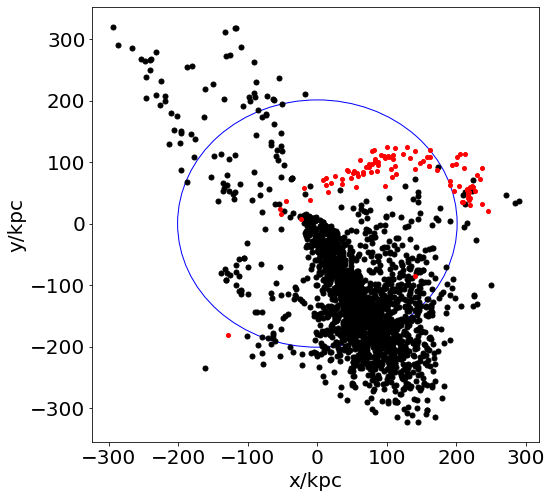

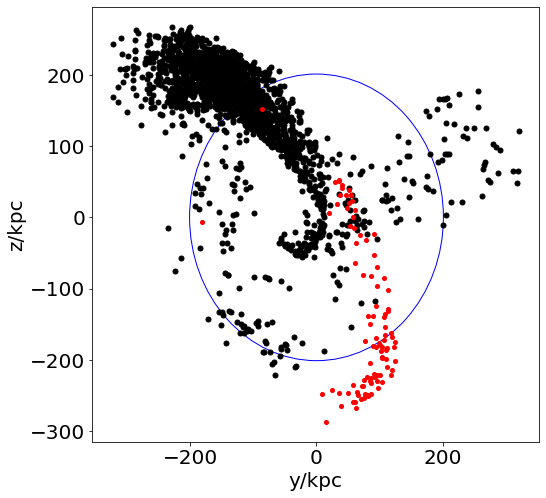

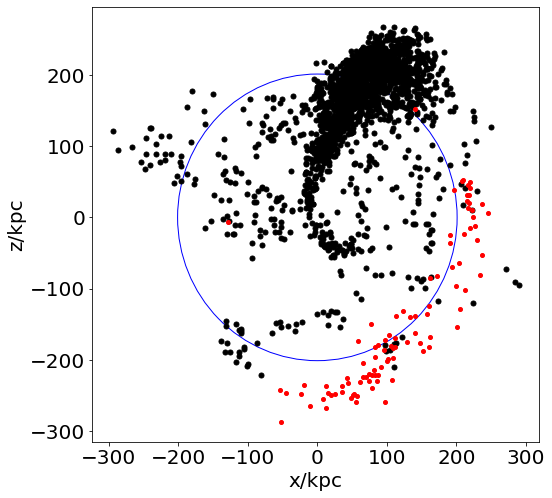

In [24]:
f1 = plt.figure(figsize=(8,8))
plt.plot(xpos_dm,ypos_dm,'k.',markersize=10)
plt.plot(xpos_stars,ypos_stars,'r.',markersize=8)
Tempcir = plt.Circle((0,0),TempestRadius,color='b',fill=False)
f1.gca().add_artist(Tempcir)
plt.xlabel('x/kpc', fontsize=20)
plt.ylabel('y/kpc', fontsize=20)
plt.show()

f2 = plt.figure(figsize=(8,8))
plt.plot(ypos_dm,zpos_dm,'k.',markersize=10)
plt.plot(ypos_stars,zpos_stars,'r.',markersize=8)
Tempcir = plt.Circle((0,0),TempestRadius,color='b',fill=False)
f2.gca().add_artist(Tempcir)
plt.xlabel('y/kpc', fontsize=20)
plt.ylabel('z/kpc', fontsize=20)
plt.show()

f2 = plt.figure(figsize=(8,8))
plt.plot(xpos_dm,zpos_dm,'k.',markersize=10)
plt.plot(xpos_stars,zpos_stars,'r.',markersize=8)
Tempcir = plt.Circle((0,0),TempestRadius,color='b',fill=False)
f2.gca().add_artist(Tempcir)
plt.xlabel('x/kpc', fontsize=20)
plt.ylabel('z/kpc', fontsize=20)
plt.show()

**There are also plenty of other ways to use tangos! A more complete set of tutorials can be found at** https://pynbody.github.io/tangos/data_exploration.html